In [73]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import os

In [74]:
# Correcting the use of torch.sqrt to accept a tensor as argument
class FitzHughNagumoNetwork(nn.Module):
    def __init__(self, n_neurons, a_base, sigma_a, b, J, epsilon, sigma, dt):
        super(FitzHughNagumoNetwork, self).__init__()
        self.n_neurons = n_neurons
        self.a_base = a_base
        self.b = b
        self.J = J
        self.epsilon = epsilon
        self.sigma = sigma
        self.sigma_a = sigma_a
        self.dt = dt
        
        # Initialize the variables v and w for all neurons
        self.v = torch.randn(n_neurons, device=device) * 0.1
        self.w = torch.randn(n_neurons, device=device) * 0.1
        
        # Coupling matrix with J/n off-diagonal elements and zeros on the diagonal
        self.coupling = (torch.ones(n_neurons, n_neurons, device=device) - torch.eye(n_neurons, device=device)) * (J / n_neurons)
    
    def cubic_nonlinearity(self, v, a):
        # Nonlinearity with heterogeneous excitability
        return v * (1 - v) * (v - a)
    
    def forward(self, tES, step):
        # Brownian motion term for the noise
        dW_brownian = torch.randn(self.n_neurons, device=device) * torch.sqrt(torch.tensor(self.dt).to(device))
        
        # Update heterogeneous excitability
        self.a = self.a_base + self.sigma_a * torch.randn(self.n_neurons, device=device)
        
        # dv = [f(v, a) - w + J/n * sum(v_j - v_i) + I(t)] * dt + sigma * dW_brownian
        # dw = epsilon * (b*v - w) * dt
        dv = (self.cubic_nonlinearity(self.v, self.a) - self.w + torch.matmul(self.coupling, self.v) + tES) * self.dt + self.sigma * dW_brownian
        dw = self.epsilon * (self.b * self.v - self.w) * self.dt
        
        # Update the variables v and w
        self.v += dv
        self.w += dw

        return self.v, self.w

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps") # for apple silicon

# Updated parameters as provided
a_base = 4       # Controls excitability, default value is 4
sigma_a = 0      # Standard deviation of the heterogeneity in excitability, default value is 0.5, or 0 for homogeneous excitability
b = 4            # Controls coupling between voltage and recovery variable, default value is 4.0
epsilon = 0.01   # Time-scale ratio of the recovery variable, default value is 0.01->7hz, 0.05->26hz, 0.1->44hz
J = 1.5          # Coupling strength, default value is 1.5
sigma = 1.5      # Level of noise, default value is 1.5
I_peak = 0       # Peak-to-peak intensity of tACS
omega = 1.0      # Frequency of the input current (rad/s)
n_neurons = 4000 # Number of neurons in the network, default value is 4000
T_mm = 1000       # total time in milliseconds, default value is 500
dt = 0.01        # Time step for the simulation, default value is 0.01

T = T_mm * 100   # Convert T from milliseconds to time steps

# Initialize the network
fhn_network = FitzHughNagumoNetwork(n_neurons, a_base, sigma_a, b, J, epsilon, sigma, dt).to(device)

# Input current using cosine function
tES = I_peak * torch.cos(omega * torch.arange(T, device=device) * dt)

# Record the membrane potentials and recovery variables over time
v_rec = torch.zeros(T, n_neurons, device=device)
w_rec = torch.zeros(T, n_neurons, device=device)

# Simulate for T time steps
for step in range(T):
    # print(step) if step % 1000 == 0 else None
    current_input = tES[step].expand(n_neurons)  # Current input is the same for all neurons at each step
    v, w = fhn_network(current_input, step)
    v_rec[step] = v
    w_rec[step] = w

# cpu 86min for 0.01*50000, gpu 17.9s
# 26, 29, 

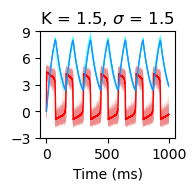

In [76]:
# Randomly select 20 neurons
selected_neurons = torch.randint(0, n_neurons, (20,))

# Extract the data for the selected neurons
selected_v_rec = v_rec[:, selected_neurons].cpu().numpy()
selected_w_rec = w_rec[:, selected_neurons].cpu().numpy()

# Compute the mean voltage for each time step
mean_v_rec = torch.mean(v_rec, dim=1).cpu().numpy()
mean_w_rec = torch.mean(w_rec, dim=1).cpu().numpy()

# Time array for plotting
time_steps = dt * torch.arange(T).cpu().numpy()

# Plotting the individual neurons
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(4.5*cm, 4.5*cm))
for neuron_data in selected_v_rec.T:
    plt.plot(time_steps, neuron_data, linewidth=0.3, color='lightcoral', alpha=0.1) # mistyrose

for neuron_data in selected_w_rec.T:
    plt.plot(time_steps, neuron_data, linewidth=0.3, color='cyan', alpha=0.5)

# Plotting the mean voltage in red
plt.plot(time_steps, mean_v_rec, linewidth=1, color='red', label='Mean Voltage')
plt.plot(time_steps, mean_w_rec, linewidth=1, color='dodgerblue', label='Mean Recovery')

# Labels and legend
plt.xlabel('Time (ms)')
# plt.ylabel('Voltage')
# plt.ylim(-100, 100)
plt.ylim(-3, 9)
plt.yticks([-3, 0, 3, 6, 9])
plt.xticks([0, 500, 1000])
plt.title('K = '+str(J) + ', $\sigma$ = '+str(sigma))
# plt.legend()
matplotlib.rcParams.update({'font.size': 10})
fig.subplots_adjust(left=0.17, bottom=0.25, right=0.93, top=0.85)
save_path = os.path.join('..', '..', '..', 'DThesis', 'chapter1', 'center.png')
plt.savefig(save_path, format='png', dpi=600)
# Show the plot
plt.show()

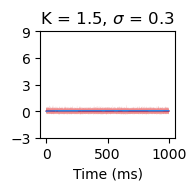

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps") # for apple silicon

# Updated parameters as provided
a_base = 4       # Controls excitability, default value is 4
sigma_a = 0      # Standard deviation of the heterogeneity in excitability, default value is 0.5, or 0 for homogeneous excitability
b = 4            # Controls coupling between voltage and recovery variable, default value is 4.0
epsilon = 0.01   # Time-scale ratio of the recovery variable, default value is 0.01->7hz, 0.05->26hz, 0.1->44hz
J = 1.5          # Coupling strength, default value is 1.5
sigma = 0.3      # Level of noise, default value is 1.5
I_peak = 0       # Peak-to-peak intensity of tACS
omega = 1.0      # Frequency of the input current (rad/s)
n_neurons = 4000 # Number of neurons in the network, default value is 4000
T_mm = 1000       # total time in milliseconds, default value is 500
dt = 0.01        # Time step for the simulation, default value is 0.01

T = T_mm * 100   # Convert T from milliseconds to time steps

# Initialize the network
fhn_network = FitzHughNagumoNetwork(n_neurons, a_base, sigma_a, b, J, epsilon, sigma, dt).to(device)

# Input current using cosine function
tES = I_peak * torch.cos(omega * torch.arange(T, device=device) * dt)

# Record the membrane potentials and recovery variables over time
v_rec = torch.zeros(T, n_neurons, device=device)
w_rec = torch.zeros(T, n_neurons, device=device)

# Simulate for T time steps
for step in range(T):
    # print(step) if step % 1000 == 0 else None
    current_input = tES[step].expand(n_neurons)  # Current input is the same for all neurons at each step
    v, w = fhn_network(current_input, step)
    v_rec[step] = v
    w_rec[step] = w


# Randomly select 20 neurons
selected_neurons = torch.randint(0, n_neurons, (20,))

# Extract the data for the selected neurons
selected_v_rec = v_rec[:, selected_neurons].cpu().numpy()
selected_w_rec = w_rec[:, selected_neurons].cpu().numpy()

# Compute the mean voltage for each time step
mean_v_rec = torch.mean(v_rec, dim=1).cpu().numpy()
mean_w_rec = torch.mean(w_rec, dim=1).cpu().numpy()

# Time array for plotting
time_steps = dt * torch.arange(T).cpu().numpy()

# Plotting the individual neurons
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(4.5*cm, 4.5*cm))
for neuron_data in selected_v_rec.T:
    plt.plot(time_steps, neuron_data, linewidth=0.3, color='lightcoral', alpha=0.1) # mistyrose

for neuron_data in selected_w_rec.T:
    plt.plot(time_steps, neuron_data, linewidth=0.3, color='cyan', alpha=0.5)

# Plotting the mean voltage in red
plt.plot(time_steps, mean_v_rec, linewidth=1, color='red', label='Mean Voltage')
plt.plot(time_steps, mean_w_rec, linewidth=1, color='dodgerblue', label='Mean Recovery')

# Labels and legend
plt.xlabel('Time (ms)')
# plt.ylabel('Voltage')
# plt.ylim(-100, 100)
plt.ylim(-3, 9)
plt.yticks([-3, 0, 3, 6, 9])
plt.xticks([0, 500, 1000])
plt.title('K = '+str(J) + ', $\sigma$ = '+str(sigma))
# plt.legend()
matplotlib.rcParams.update({'font.size': 10})
fig.subplots_adjust(left=0.17, bottom=0.25, right=0.93, top=0.85)
save_path = os.path.join('..', '..', '..', 'DThesis', 'chapter1', 'left.png')
plt.savefig(save_path, format='png', dpi=600)
# Show the plot
plt.show()

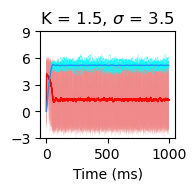

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps") # for apple silicon

# Updated parameters as provided
a_base = 4       # Controls excitability, default value is 4
sigma_a = 0      # Standard deviation of the heterogeneity in excitability, default value is 0.5, or 0 for homogeneous excitability
b = 4            # Controls coupling between voltage and recovery variable, default value is 4.0
epsilon = 0.01   # Time-scale ratio of the recovery variable, default value is 0.01->7hz, 0.05->26hz, 0.1->44hz
J = 1.5          # Coupling strength, default value is 1.5
sigma = 3.5      # Level of noise, default value is 1.5
I_peak = 0       # Peak-to-peak intensity of tACS
omega = 1.0      # Frequency of the input current (rad/s)
n_neurons = 4000 # Number of neurons in the network, default value is 4000
T_mm = 1000       # total time in milliseconds, default value is 500
dt = 0.01        # Time step for the simulation, default value is 0.01

T = T_mm * 100   # Convert T from milliseconds to time steps

# Initialize the network
fhn_network = FitzHughNagumoNetwork(n_neurons, a_base, sigma_a, b, J, epsilon, sigma, dt).to(device)

# Input current using cosine function
tES = I_peak * torch.cos(omega * torch.arange(T, device=device) * dt)

# Record the membrane potentials and recovery variables over time
v_rec = torch.zeros(T, n_neurons, device=device)
w_rec = torch.zeros(T, n_neurons, device=device)

# Simulate for T time steps
for step in range(T):
    # print(step) if step % 1000 == 0 else None
    current_input = tES[step].expand(n_neurons)  # Current input is the same for all neurons at each step
    v, w = fhn_network(current_input, step)
    v_rec[step] = v
    w_rec[step] = w


# Randomly select 20 neurons
selected_neurons = torch.randint(0, n_neurons, (20,))

# Extract the data for the selected neurons
selected_v_rec = v_rec[:, selected_neurons].cpu().numpy()
selected_w_rec = w_rec[:, selected_neurons].cpu().numpy()

# Compute the mean voltage for each time step
mean_v_rec = torch.mean(v_rec, dim=1).cpu().numpy()
mean_w_rec = torch.mean(w_rec, dim=1).cpu().numpy()

# Time array for plotting
time_steps = dt * torch.arange(T).cpu().numpy()

# Plotting the individual neurons
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(4.5*cm, 4.5*cm))
for neuron_data in selected_v_rec.T:
    plt.plot(time_steps, neuron_data, linewidth=0.3, color='lightcoral', alpha=0.1) # mistyrose

for neuron_data in selected_w_rec.T:
    plt.plot(time_steps, neuron_data, linewidth=0.3, color='cyan', alpha=0.5)

# Plotting the mean voltage in red
plt.plot(time_steps, mean_v_rec, linewidth=1, color='red', label='Mean Voltage')
plt.plot(time_steps, mean_w_rec, linewidth=1, color='dodgerblue', label='Mean Recovery')

# Labels and legend
plt.xlabel('Time (ms)')
# plt.ylabel('Voltage')
# plt.ylim(-100, 100)
plt.ylim(-3, 9)
plt.yticks([-3, 0, 3, 6, 9])
plt.xticks([0, 500, 1000])
plt.title('K = '+str(J) + ', $\sigma$ = '+str(sigma))
# plt.legend()
matplotlib.rcParams.update({'font.size': 10})
fig.subplots_adjust(left=0.17, bottom=0.25, right=0.93, top=0.85)
save_path = os.path.join('..', '..', '..', 'DThesis', 'chapter1', 'right.png')
plt.savefig(save_path, format='png', dpi=600)
# Show the plot
plt.show()

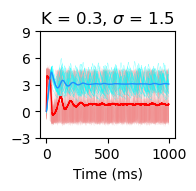

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps") # for apple silicon

# Updated parameters as provided
a_base = 4       # Controls excitability, default value is 4
sigma_a = 0      # Standard deviation of the heterogeneity in excitability, default value is 0.5, or 0 for homogeneous excitability
b = 4            # Controls coupling between voltage and recovery variable, default value is 4.0
epsilon = 0.01   # Time-scale ratio of the recovery variable, default value is 0.01->7hz, 0.05->26hz, 0.1->44hz
J = 0.3          # Coupling strength, default value is 1.5
sigma = 1.5      # Level of noise, default value is 1.5
I_peak = 0       # Peak-to-peak intensity of tACS
omega = 1.0      # Frequency of the input current (rad/s)
n_neurons = 4000 # Number of neurons in the network, default value is 4000
T_mm = 1000       # total time in milliseconds, default value is 500
dt = 0.01        # Time step for the simulation, default value is 0.01

T = T_mm * 100   # Convert T from milliseconds to time steps

# Initialize the network
fhn_network = FitzHughNagumoNetwork(n_neurons, a_base, sigma_a, b, J, epsilon, sigma, dt).to(device)

# Input current using cosine function
tES = I_peak * torch.cos(omega * torch.arange(T, device=device) * dt)

# Record the membrane potentials and recovery variables over time
v_rec = torch.zeros(T, n_neurons, device=device)
w_rec = torch.zeros(T, n_neurons, device=device)

# Simulate for T time steps
for step in range(T):
    # print(step) if step % 1000 == 0 else None
    current_input = tES[step].expand(n_neurons)  # Current input is the same for all neurons at each step
    v, w = fhn_network(current_input, step)
    v_rec[step] = v
    w_rec[step] = w


# Randomly select 20 neurons
selected_neurons = torch.randint(0, n_neurons, (20,))

# Extract the data for the selected neurons
selected_v_rec = v_rec[:, selected_neurons].cpu().numpy()
selected_w_rec = w_rec[:, selected_neurons].cpu().numpy()

# Compute the mean voltage for each time step
mean_v_rec = torch.mean(v_rec, dim=1).cpu().numpy()
mean_w_rec = torch.mean(w_rec, dim=1).cpu().numpy()

# Time array for plotting
time_steps = dt * torch.arange(T).cpu().numpy()

# Plotting the individual neurons
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(4.5*cm, 4.5*cm))
for neuron_data in selected_v_rec.T:
    plt.plot(time_steps, neuron_data, linewidth=0.3, color='lightcoral', alpha=0.1) # mistyrose

for neuron_data in selected_w_rec.T:
    plt.plot(time_steps, neuron_data, linewidth=0.3, color='cyan', alpha=0.5)

# Plotting the mean voltage in red
plt.plot(time_steps, mean_v_rec, linewidth=1, color='red', label='Mean Voltage')
plt.plot(time_steps, mean_w_rec, linewidth=1, color='dodgerblue', label='Mean Recovery')

# Labels and legend
plt.xlabel('Time (ms)')
# plt.ylabel('Voltage')
# plt.ylim(-100, 100)
plt.ylim(-3, 9)
plt.yticks([-3, 0, 3, 6, 9])
plt.xticks([0, 500, 1000])
plt.title('K = '+str(J) + ', $\sigma$ = '+str(sigma))
# plt.legend()
matplotlib.rcParams.update({'font.size': 10})
fig.subplots_adjust(left=0.17, bottom=0.25, right=0.93, top=0.85)
save_path = os.path.join('..', '..', '..', 'DThesis', 'chapter1', 'bottom.png')
plt.savefig(save_path, format='png', dpi=600)
# Show the plot
plt.show()

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps") # for apple silicon

# Updated parameters as provided
a_base = 4       # Controls excitability, default value is 4
sigma_a = 0      # Standard deviation of the heterogeneity in excitability, default value is 0.5, or 0 for homogeneous excitability
b = 4            # Controls coupling between voltage and recovery variable, default value is 4.0
epsilon = 0.01   # Time-scale ratio of the recovery variable, default value is 0.01->7hz, 0.05->26hz, 0.1->44hz
J = 3.6          # Coupling strength, default value is 1.5
sigma = 1.5      # Level of noise, default value is 1.5
I_peak = 0       # Peak-to-peak intensity of tACS
omega = 1.0      # Frequency of the input current (rad/s)
n_neurons = 4000 # Number of neurons in the network, default value is 4000
T_mm = 1000       # total time in milliseconds, default value is 500
dt = 0.01        # Time step for the simulation, default value is 0.01

T = T_mm * 100   # Convert T from milliseconds to time steps

# Initialize the network
fhn_network = FitzHughNagumoNetwork(n_neurons, a_base, sigma_a, b, J, epsilon, sigma, dt).to(device)

# Input current using cosine function
tES = I_peak * torch.cos(omega * torch.arange(T, device=device) * dt)

# Record the membrane potentials and recovery variables over time
v_rec = torch.zeros(T, n_neurons, device=device)
w_rec = torch.zeros(T, n_neurons, device=device)

# Simulate for T time steps
for step in range(T):
    # print(step) if step % 1000 == 0 else None
    current_input = tES[step].expand(n_neurons)  # Current input is the same for all neurons at each step
    v, w = fhn_network(current_input, step)
    v_rec[step] = v
    w_rec[step] = w


# Randomly select 20 neurons
selected_neurons = torch.randint(0, n_neurons, (20,))

# Extract the data for the selected neurons
selected_v_rec = v_rec[:, selected_neurons].cpu().numpy()
selected_w_rec = w_rec[:, selected_neurons].cpu().numpy()

# Compute the mean voltage for each time step
mean_v_rec = torch.mean(v_rec, dim=1).cpu().numpy()
mean_w_rec = torch.mean(w_rec, dim=1).cpu().numpy()

# Time array for plotting
time_steps = dt * torch.arange(T).cpu().numpy()

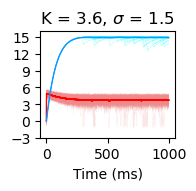

In [81]:

# Plotting the individual neurons
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(4.5*cm, 4.5*cm))
for neuron_data in selected_v_rec.T:
    plt.plot(time_steps, neuron_data, linewidth=0.3, color='lightcoral', alpha=0.1) # mistyrose

for neuron_data in selected_w_rec.T:
    plt.plot(time_steps, neuron_data, linewidth=0.3, color='cyan', alpha=0.5)

# Plotting the mean voltage in red
plt.plot(time_steps, mean_v_rec, linewidth=1, color='red', label='Mean Voltage')
plt.plot(time_steps, mean_w_rec, linewidth=1, color='dodgerblue', label='Mean Recovery')

# Labels and legend
plt.xlabel('Time (ms)')
# plt.ylabel('Voltage')
# plt.ylim(-100, 100)
plt.ylim(-3,16)
plt.yticks([-3, 0, 3, 6, 9, 12, 15])
plt.xticks([0, 500, 1000])
plt.title('K = '+str(J) + ', $\sigma$ = '+str(sigma))
# plt.legend()
matplotlib.rcParams.update({'font.size': 10})
fig.subplots_adjust(left=0.17, bottom=0.25, right=0.93, top=0.85)
save_path = os.path.join('..', '..', '..', 'DThesis', 'chapter1', 'top.png')
plt.savefig(save_path, format='png', dpi=600)
# Show the plot
plt.show()

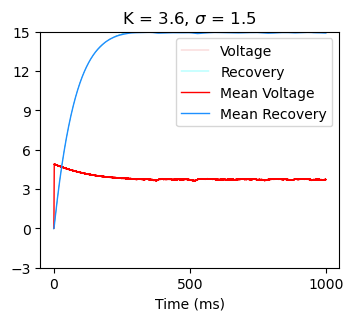

In [87]:
# make legend
# Plotting the individual neurons
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(10*cm, 10*cm))
plt.plot(time_steps, neuron_data, linewidth=0.3, color='lightcoral', label='Voltage') # mistyrose

plt.plot(time_steps, neuron_data, linewidth=0.3, color='cyan', label='Recovery')

# Plotting the mean voltage in red
plt.plot(time_steps, mean_v_rec, linewidth=1, color='red', label='Mean Voltage')
plt.plot(time_steps, mean_w_rec, linewidth=1, color='dodgerblue', label='Mean Recovery')

# Labels and legend
plt.xlabel('Time (ms)')
# plt.ylabel('Voltage')
# plt.ylim(-100, 100)
plt.ylim(-3,1)
plt.yticks([-3, 0, 3, 6, 9, 12, 15])
plt.xticks([0, 500, 1000])
plt.title('K = '+str(J) + ', $\sigma$ = '+str(sigma))
plt.legend()
matplotlib.rcParams.update({'font.size': 10})
fig.subplots_adjust(left=0.17, bottom=0.25, right=0.93, top=0.85)
save_path = os.path.join('..', '..', '..', 'DThesis', 'chapter1', 'legend.png')
plt.savefig(save_path, format='png', dpi=600)
# Show the plot
plt.show()